# Analysis: Random Forest
**Primary Analyst:** Alvin Jeffery

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from sklearn import preprocessing, model_selection
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import make_scorer, confusion_matrix, f1_score, roc_auc_score

## Load Data

In [8]:
train = pd.read_csv('../data/train_imputed.csv').drop(columns='Unnamed: 0')
valid = pd.read_csv('../data/valid_imputed.csv').drop(columns='Unnamed: 0')
test = pd.read_csv('../data/test_imputed.csv').drop(columns='Unnamed: 0')

In [9]:
y_train = train.pop('readmit_30d')
X_train = train.copy()
X_train.shape

(12912, 208)

In [10]:
y_valid = valid.pop('readmit_30d')
X_valid = valid.copy()
X_valid.shape

(3992, 208)

In [11]:
y_test = test.pop('readmit_30d')
X_test = test.copy()
X_test.shape

(4229, 208)

## Coerce Categories (`sex` and `race`)

In [12]:
X_train = pd.get_dummies(X_train, columns=['sex', 'race'])
X_train.head()

,stay_length,n_transfers,cpt_anesthesia,cpt_eval_manage,cpt_expired,cpt_medicine,cpt_modifier,cpt_path_lab,cpt_radiology,cpt_surgery,...,sex_F,sex_M,sex_U,race_A,race_B,race_H,race_I,race_N,race_U,race_W
0,4,2,0,6,4,16,9,24,9,2,...,1,0,0,0,0,0,0,0,0,1
1,3,3,0,2,1,16,15,39,1,0,...,1,0,0,0,0,0,0,0,0,1
2,1,1,0,3,0,7,4,13,1,0,...,1,0,0,0,0,0,0,0,0,1
3,4,2,0,6,1,4,8,47,2,2,...,1,0,0,0,0,0,0,0,0,1
4,1,1,0,1,1,2,3,21,1,0,...,1,0,0,0,0,0,0,0,0,1


In [13]:
X_valid = pd.get_dummies(X_valid, columns=['sex', 'race'])
X_test = pd.get_dummies(X_test, columns=['sex', 'race'])

## Preliminary Model

In [15]:
scorer = {'f1': make_scorer(f1_score)}
rf = RandomForestClassifier()

In [ ]:
max_features = [5, 10, 15, 20]
n_estimators = [100, 500, 1000]

# Create the grid
parameter_grid = {'max_features': max_features, 
                  'n_estimators': n_estimators}

In [ ]:
rf_cv = model_selection.GridSearchCV(estimator=rf, cv=5, n_jobs=3, param_grid=parameter_grid,
                                     scoring=scorer, refit='f1')

rf_cv.fit(X_train, y_train)

In [ ]:
rf_cv.best_estimator_.get_params()

In [ ]:
rf_cv.best_score_

In [ ]:
predictions = rf_cv.best_estimator_.predict(X_valid)
f1_score(y_valid, predictions)

In [ ]:
roc_auc_score(y_valid, predictions)

In [ ]:
confusion_matrix(y_valid, predictions)

In [53]:
rf = RandomForestClassifier(n_estimators=500, max_features=50, max_depth=3, n_jobs=3)
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=3, max_features=50, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=3,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [54]:
predictions = rf.predict(X_valid)
f1_score(y_valid, predictions)

0.0

In [55]:
roc_auc_score(y_valid, predictions)

0.4996617050067659

In [36]:
def feature_importance(rf, train, pred_cols):
    importances = rf.feature_importances_
    std = np.std([tree.feature_importances_ for tree in rf.estimators_],
                 axis=0)
    indices = np.argsort(importances)[::-1]
    predictors = train[pred_cols].columns
    X = train[pred_cols]

    # Print the feature ranking
    print("Feature ranking:")
    #for f in range(X.shape[1]): # all features
    for f in range(5): # top 5 only
        print("%d. %s (%f)" % (f + 1, predictors[indices[f]], importances[indices[f]]))
    
    return X, importances, std, predictors, indices

Feature ranking:
1. rdw_5p (0.019229)
2. rdw_95p (0.016851)
3. rdw_median (0.016774)
4. age (0.014743)
5. gluc_95p (0.012782)


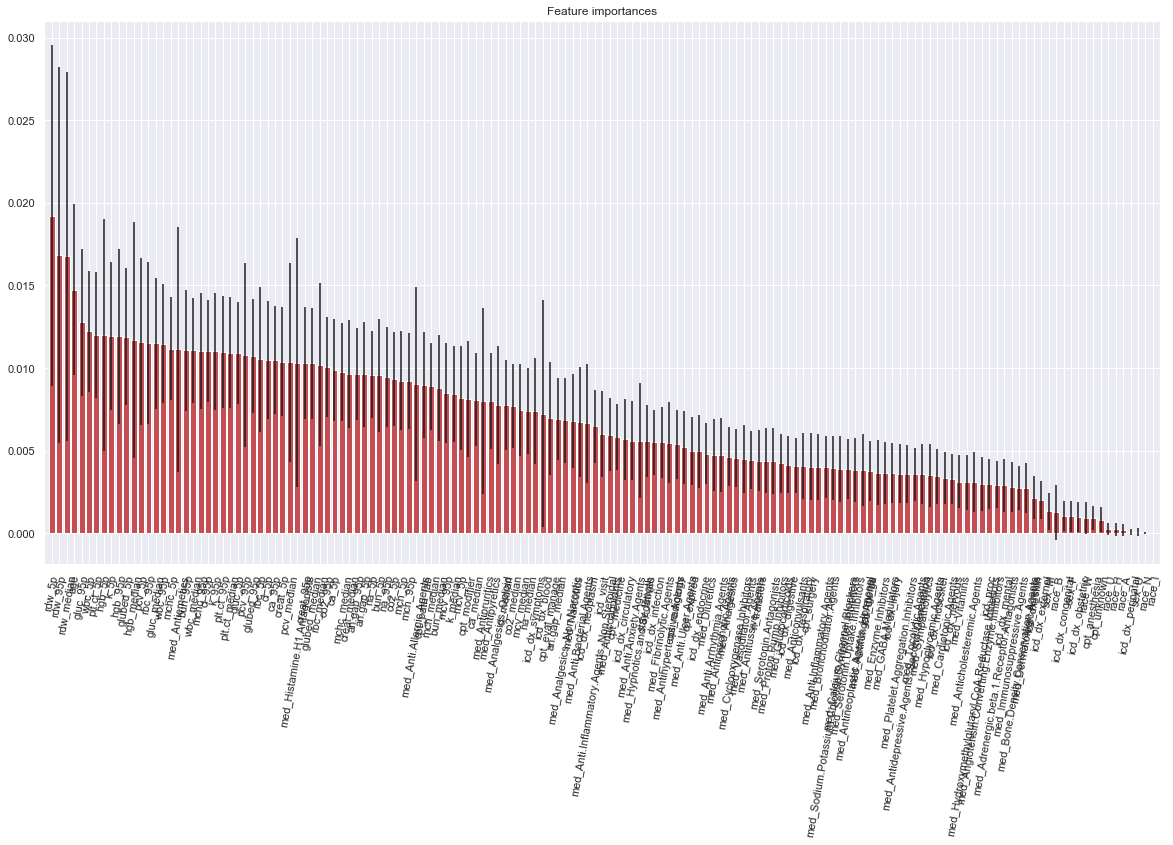

In [39]:
x, importances, std, predictors, indices = feature_importance(rf=rf, train=X_train, pred_cols=X_train.columns)

plt.figure(figsize=(20,10)); plt.title("Feature importances")
plt.bar(range(x.shape[1]), importances[indices], color="r", yerr=std[indices], align="center")
plt.xticks(range(x.shape[1]), predictors[indices], rotation=80); plt.xlim([-1, x.shape[1]])
plt.show()

In [59]:
from sklearn.ensemble.partial_dependence import partial_dependence, plot_partial_dependence

In [ ]:
gbc = GradientBoostingClassifier(n_estimators=1000, 
                                 max_features=100, 
                                 random_state=42,
                                 warm_start=True)
gbc.fit(X_train, y_train)

In [ ]:
predictions = gbc.predict(X_valid)
f1_score(y_valid, predictions)

In [ ]:
roc_auc_score(y_valid, predictions)

Text(0.5,0.98,'Partial dependence on age')

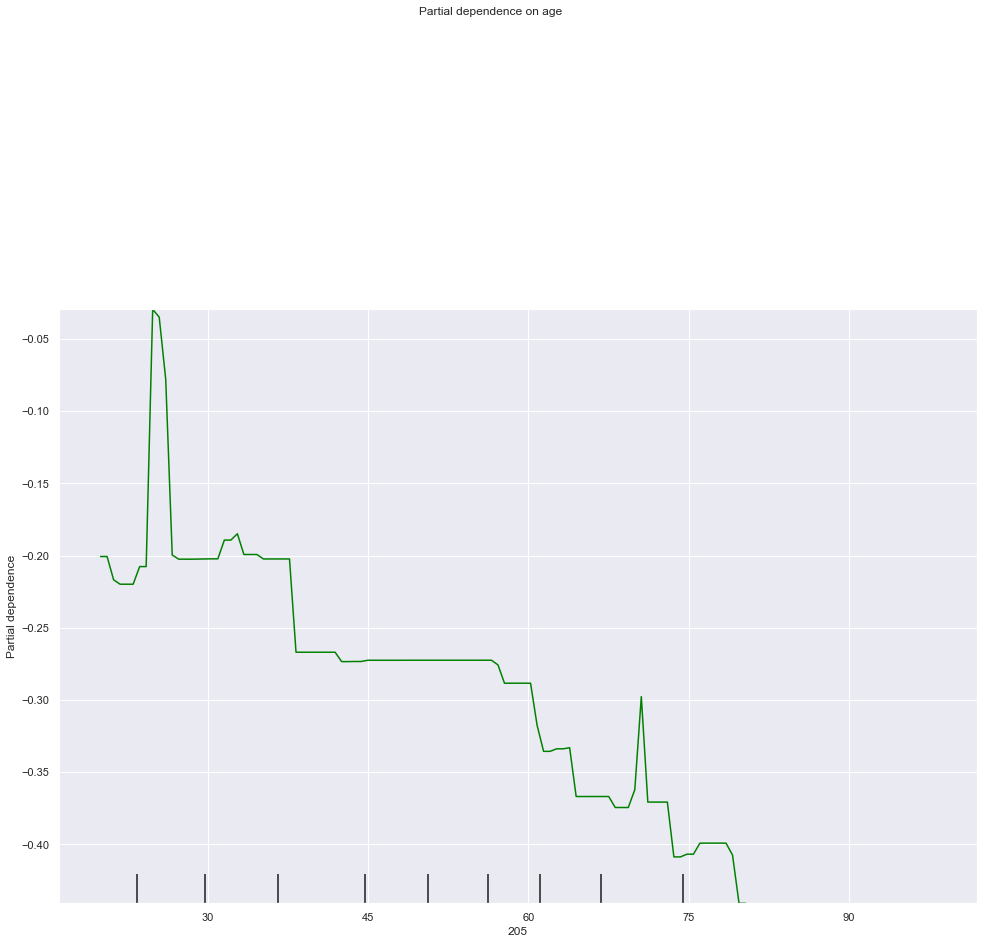

In [67]:
plt.rcParams["figure.figsize"] = (15, 15)

var = 'age'
idx = X_train.columns.get_loc(var)

my_plot, ax = plot_partial_dependence(gbc, features=[idx], X=X_train)
axes = plt.gca()
axes.set_xlim([min(X_train[var]), max(X_train[var])])
my_plot.suptitle('Partial dependence on ' + var)